In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import glob
import math
import seaborn as sns 
import matplotlib.pyplot as plt
import toad
import pickle

In [2]:
df_train = pd.read_csv("application_train.csv")
df_train = df_train[df_train['DAYS_EMPLOYED'] <= 0]
df_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
289349,435220,0,Cash loans,F,N,Y,0,112500.0,349258.5,17959.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
175054,302854,0,Cash loans,M,Y,Y,0,166500.0,450000.0,32742.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,7.0
168472,295283,0,Cash loans,M,Y,Y,2,166500.0,1014340.5,68188.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
201069,333071,0,Cash loans,F,N,Y,0,135000.0,1096020.0,48406.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,5.0
183580,312780,0,Cash loans,F,N,Y,0,99000.0,143910.0,14148.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
79805,192515,0,Cash loans,F,N,N,0,175500.0,1134000.0,31185.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,4.0
129263,249936,0,Revolving loans,M,Y,Y,1,216000.0,157500.0,7875.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
139969,262303,0,Cash loans,M,Y,Y,2,157500.0,301464.0,23818.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
29283,134010,0,Cash loans,M,Y,Y,1,135000.0,900000.0,26446.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
120063,239230,0,Cash loans,M,N,Y,2,157500.0,67500.0,7047.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
test_size = 0.2
split_index = int(len(df_train) * (1 - test_size))  

# Membagi dataset
train_data = df_train.iloc[:split_index]  
test_data = df_train.iloc[split_index:]  

# Verifikasi
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (201709, 122)
Test data shape: (50428, 122)


In [4]:
# set an exclude list for the scorecard package Toad
exclude_list = ['SK_ID_CURR','TARGET']

train_selected, drop_lst= toad.selection.select(frame = train_data,
                                                target=train_data['TARGET'], 
                                                empty = 0.5, 
                                                iv = 0.02, corr = 1, 
                                                return_drop=True, 
                                                exclude=exclude_list)
print("keep:",train_selected.shape[1],
      "drop empty:",len(drop_lst['empty']),
      "drop iv:",len(drop_lst['iv']),
      "drop corr:",len(drop_lst['corr']))

keep: 31 drop empty: 41 drop iv: 50 drop corr: 0


In [5]:
# output the iv table to a dataframe
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv

df_iv=output_iv_importance(train_selected,'TARGET')
df_iv.head(20)

,name,iv
0,EXT_SOURCE_2,0.341342
1,EXT_SOURCE_3,0.321662
2,AMT_GOODS_PRICE,0.112443
3,DAYS_EMPLOYED,0.098843
4,AMT_CREDIT,0.075246
5,OCCUPATION_TYPE,0.071968
6,NAME_EDUCATION_TYPE,0.067126
7,DAYS_BIRTH,0.060863
8,REGION_RATING_CLIENT_W_CITY,0.060393
9,DAYS_LAST_PHONE_CHANGE,0.059582


## Feature Binning

In [6]:
import time
start = time.time()
combiner = toad.transform.Combiner()

combiner.fit(X=train_selected,
             y=train_selected['TARGET'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

#output binning
bins = combiner.export()

5.309934039910634


<Axes: xlabel='CODE_GENDER', ylabel='prop'>

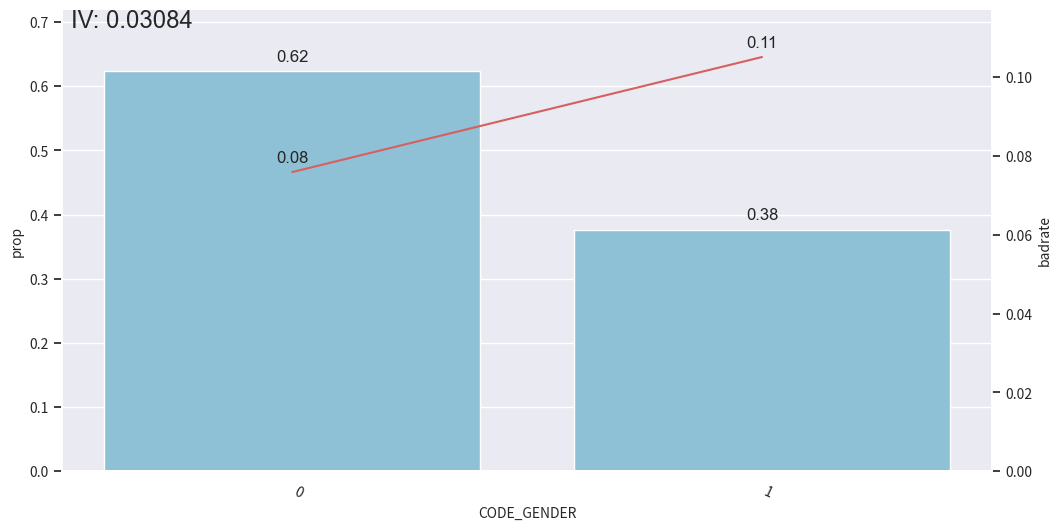

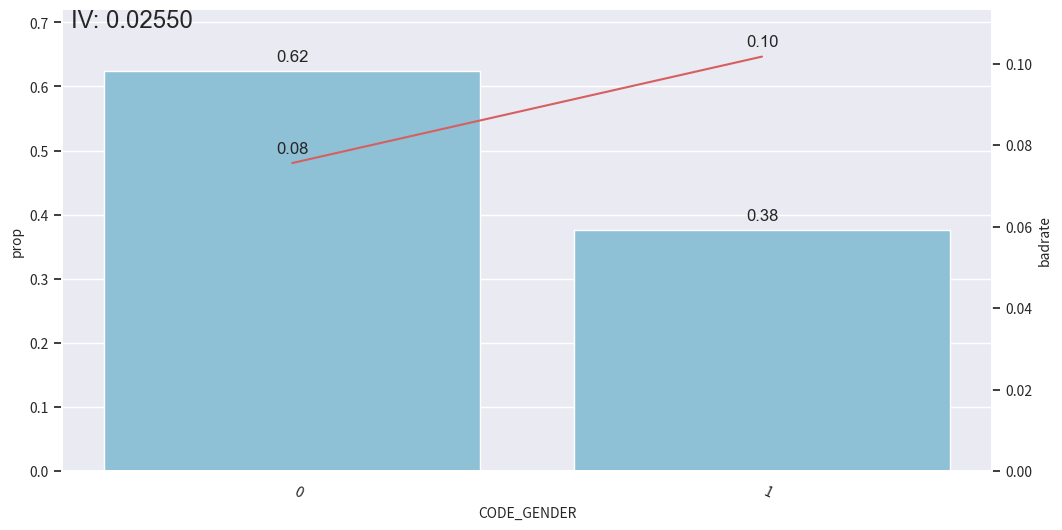

In [7]:
#apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(test_data[train_selected_bin.columns])

#Fine tune bins
from toad.plot import  bin_plot,badrate_plot
bin_plot(train_selected_bin,x='CODE_GENDER',target='TARGET')
bin_plot(test_bin,x='CODE_GENDER',target='TARGET')

## Weight of Evidence

In [8]:
##transform to WOE
t=toad.transform.WOETransformer()
#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['TARGET'], 
                            exclude=exclude_list)

test_woe = t.transform(test_bin)

train_woe = train_woe.drop(columns=['CODE_GENDER','DAYS_EMPLOYED'])
test_woe = test_woe.drop(columns=['CODE_GENDER','DAYS_EMPLOYED'])

final_data_woe = pd.concat([train_woe,test_woe])

In [9]:
#get the feature name
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list])
#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})

# features less than 0.25
psi005 = list(psi_df[psi_df.psi<0.25].feature)
# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)

# keep exclude list
for i in exclude_list:
    if i in psi005:
        pass
    else:
       psi005.append(i) 
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe[psi005]
off_woe_psi = test_woe[psi005]

# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi,off_woe_psi])

In [10]:
df_iv = df_iv.rename(columns={'name': 'feature'})

result_df = df_iv[['feature','iv']].merge(psi_df[['feature','psi']], on='feature', how='inner')
result_df = result_df.sort_values(by='iv', ascending=False).reset_index(drop=True)

print(result_df)

                         feature        iv           psi
0                   EXT_SOURCE_2  0.341342  2.580302e-04
1                   EXT_SOURCE_3  0.321662  3.937734e-04
2                AMT_GOODS_PRICE  0.112443  7.349129e-05
3                     AMT_CREDIT  0.075246  1.111596e-04
4                OCCUPATION_TYPE  0.071968  2.853560e-06
5            NAME_EDUCATION_TYPE  0.067126  4.051783e-05
6                     DAYS_BIRTH  0.060863  2.051576e-04
7    REGION_RATING_CLIENT_W_CITY  0.060393  9.512942e-07
8         DAYS_LAST_PHONE_CHANGE  0.059582  2.517155e-04
9     REGION_POPULATION_RELATIVE  0.056867  7.309273e-05
10          REGION_RATING_CLIENT  0.056688  2.141505e-07
11             ORGANIZATION_TYPE  0.046769  1.391402e-04
12                 FLOORSMAX_AVG  0.046642  7.133816e-05
13                FLOORSMAX_MEDI  0.046299  8.405401e-05
14                FLOORSMAX_MODE  0.045782  6.437653e-05
15                TOTALAREA_MODE  0.044936  1.027512e-04
16                   AMT_ANNUIT

In [11]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

df_iv=output_iv_importance(final_data_woe[features_use+['TARGET']],'TARGET')

In [12]:
def check_train_test_auc(x_train,y_train,x_test,y_test):
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg')

  
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)

    pred_train = lr.predict_proba(x_train)[:,1]
    from toad.metrics import KS, AUC

    print('train KS',KS(pred_train, y_train))
    print('train AUC',AUC(pred_train, y_train))
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('Test KS',KS(pred_OOT, y_test))
    print('Test AUC',AUC(pred_OOT, y_test))
    
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

#train & test
check_train_test_auc(x_train = train_woe[features_use],y_train=train_woe['TARGET'],
                     x_test =test_woe[features_use] ,y_test = test_woe['TARGET'])

train KS 0.3439214845051722
train AUC 0.7329458895857472
Test KS 0.34802008164080467
Test AUC 0.7310487869841784


### Decision Tree

Decision Tree with SMOTE ROC-AUC: 0.6821244672973736
[[30541 15579]
 [ 1624  2684]]
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     46120
           1       0.15      0.62      0.24      4308

    accuracy                           0.66     50428
   macro avg       0.55      0.64      0.51     50428
weighted avg       0.88      0.66      0.73     50428



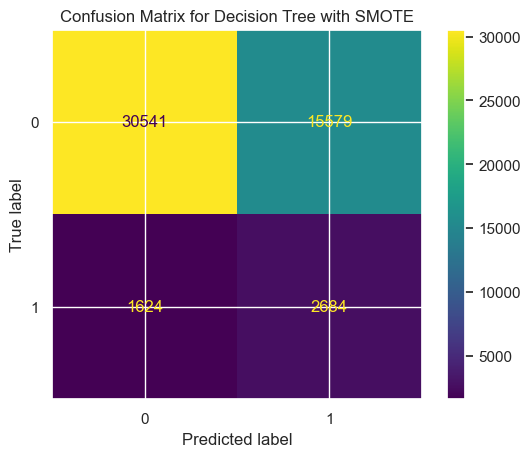

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# SMOTE and Decision Tree implementation
def evaluate_with_smote(X_train, y_train, X_test, y_test):
    # Oversample using SMOTE
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Initialize Decision Tree
    model = DecisionTreeClassifier(max_depth=5, random_state=0)
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"Decision Tree with SMOTE ROC-AUC: {roc_auc}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix for Decision Tree with SMOTE")
    plt.show()

    return model

# Call the function
model = evaluate_with_smote(
    X_train=train_woe[features_use],
    y_train=train_woe['TARGET'],
    X_test=test_woe[features_use],
    y_test=test_woe['TARGET']
)

c:\Users\rizar\anaconda3\envs\data_science_env\lib\site-packages\xgboost\core.py:158: UserWarning: [14:37:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost with ADASYN ROC-AUC: 0.7187892379976824
[[46027    93]
 [ 4236    72]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     46120
           1       0.44      0.02      0.03      4308

    accuracy                           0.91     50428
   macro avg       0.68      0.51      0.49     50428
weighted avg       0.87      0.91      0.88     50428



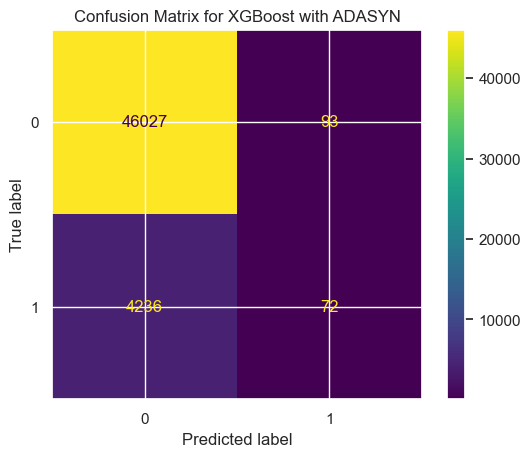

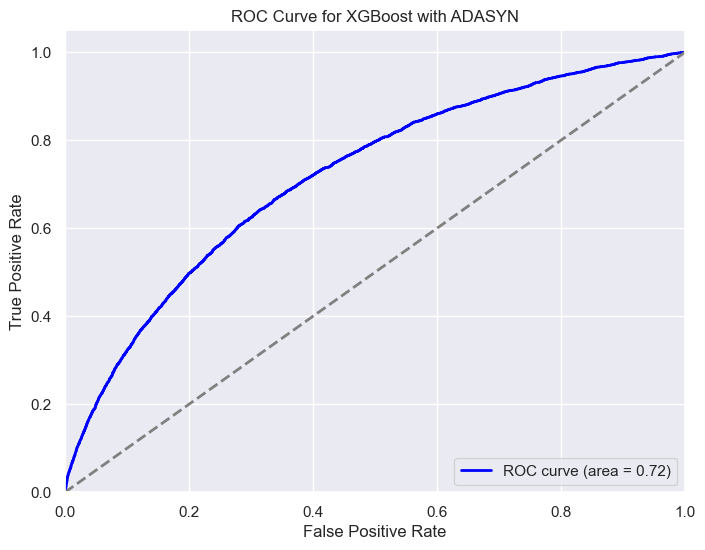

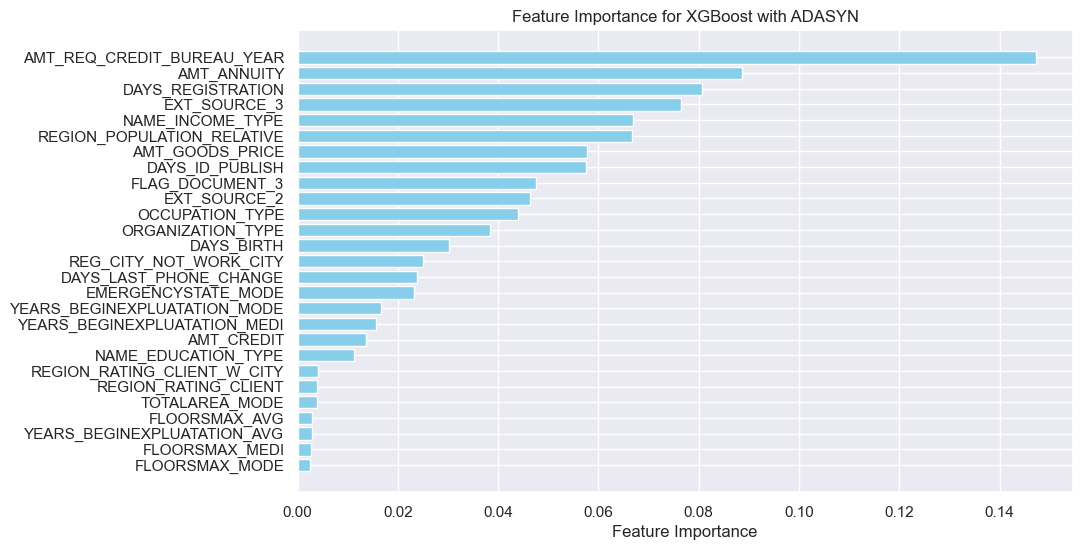

In [14]:
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# SMOTE and XGBoost implementation with ADASYN
def evaluate_with_adasyn_xgboost(X_train, y_train, X_test, y_test, features, sampling_strategy=0.6):
    # Oversample using ADASYN with a 60:40 ratio (60% minority, 40% majority)
    adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=0)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

    # Initialize XGBoost
    model = XGBClassifier(
        n_estimators=250, 
        random_state=13, 
        use_label_encoder=False,      
    )
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"XGBoost with ADASYN ROC-AUC: {roc_auc}")

    # Confusion Matrix and Classification Report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix for XGBoost with ADASYN")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc_curve = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_curve:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost with ADASYN')
    plt.legend(loc="lower right")
    plt.show()

    # Feature Importance
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    })
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for XGBoost with ADASYN')
    plt.gca().invert_yaxis()
    plt.show()

    return model, feature_importance_df

# Call
model_xgboost_adasyn, feature_importance_df = evaluate_with_adasyn_xgboost(
    X_train=train_woe[features_use],
    y_train=train_woe['TARGET'],
    X_test=test_woe[features_use],
    y_test=test_woe['TARGET'],
    features=features_use
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Prepare train & test data
x_train = train_woe[features_use]
y_train = train_woe['TARGET']
x_test = test_woe[features_use]
y_test = test_woe['TARGET']

smote = SMOTE(random_state=0)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Train Logistic Regression with class_weight='balanced'
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)

# Get predicted probabilities for the positive class (class 1)
probs = lr.predict_proba(x_test)[:, 1]

# Calculate AUC
roc_auc = roc_auc_score(y_test, probs)
print(f"Logistic Regression AUC: {roc_auc}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc_curve = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Precision: 0.1589
Recall: 0.6783
F1-Score: 0.2574

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.66      0.78     46120
           1       0.16      0.68      0.26      4308

    accuracy                           0.67     50428
   macro avg       0.56      0.67      0.52     50428
weighted avg       0.89      0.67      0.74     50428

Logistic Regression AUC: 0.7310


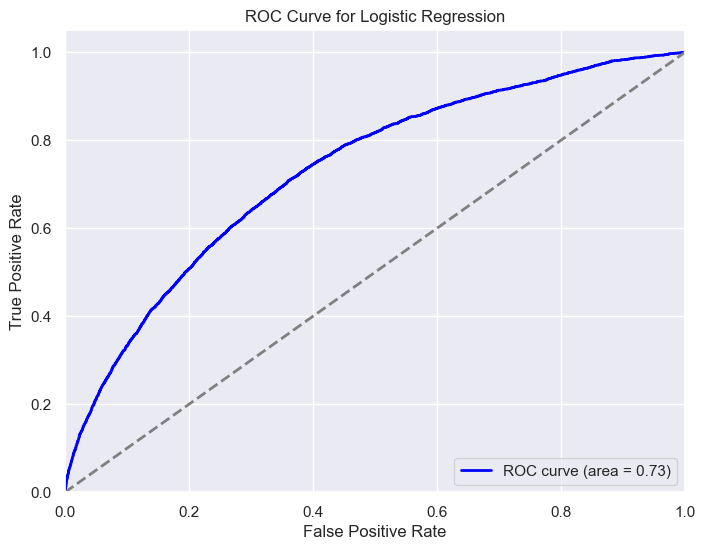

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

y_pred = lr.predict(x_test)

#Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Evaluate the model
roc_auc = roc_auc_score(y_test, probs)
print(f"Logistic Regression AUC: {roc_auc:.4f}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc_curve = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()


In [16]:
# scorecard tuning
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['TARGET'])

#inference on test data
test_data['CreditScore'] = card.predict(test_data)
test_data['CreditScore'].describe()

#output the scorecard
final_card_score=card.export()
len(final_card_score)

#transform the scorecard into dataframe
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df = pd.concat([score_card_df, temp], ignore_index=True)
score_card_df.head(30)

C:\Users\rizar\AppData\Local\Temp\ipykernel_16532\2430345013.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['CreditScore'] = card.predict(test_data)


,variable,binning,score
0,AMT_CREDIT,[-inf ~ 275040.0),22.65
1,AMT_CREDIT,[275040.0 ~ 454500.0),19.44
2,AMT_CREDIT,[454500.0 ~ 545040.0),21.02
3,AMT_CREDIT,[545040.0 ~ 640458.0),18.21
4,AMT_CREDIT,[640458.0 ~ 900000.0),22.57
5,AMT_CREDIT,[900000.0 ~ 1345500.0),24.26
6,AMT_CREDIT,[1345500.0 ~ inf),28.78
7,AMT_ANNUITY,[-inf ~ 26509.5),21.73
8,AMT_ANNUITY,[26509.5 ~ 46179.0),20.41
9,AMT_ANNUITY,[46179.0 ~ inf),28.97


## Test data

In [17]:
application_test = pd.read_csv("application_test.csv")

selected_features = [feature for feature in train_selected.columns if feature != 'TARGET']
application_selected = application_test[selected_features]

In [18]:
print(train_selected.columns)

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE',
       'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')


In [19]:
import time
start = time.time()
combiner = toad.transform.Combiner()

combiner.fit(X=train_selected,
             y=train_selected['TARGET'],
             method='chi',
             min_samples = 0.05,
             exclude=exclude_list)
end = time.time()
print((end-start)/60)

#output binning
bins = combiner.export()

5.438850140571594


In [20]:
# Apply binning
train_selected_bin = combiner.transform(train_selected)
test_bin = combiner.transform(application_selected)  # Test data

In [21]:
# Apply WOE
t = toad.transform.WOETransformer()

# Train
train_woe = t.fit_transform(X=train_selected_bin, 
                            y=train_selected['TARGET'], 
                            exclude=exclude_list)

# Apply to test
test_woe = t.transform(test_bin)

# Drop GENDER
train_woe = train_woe.drop(columns=['CODE_GENDER','DAYS_EMPLOYED'])
test_woe = test_woe.drop(columns=['CODE_GENDER','DAYS_EMPLOYED'])

final_data_woe = pd.concat([train_woe, test_woe])

In [22]:
# Step 3: PSI Calculation
features_list = [feat for feat in train_woe.columns if feat not in exclude_list]
psi_df = toad.metrics.PSI(train_woe[features_list], test_woe[features_list])

# Put into a dataframe and calculate PSI values
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature', 0:'psi'})

# Identify features with PSI < 0.25 and features with PSI >= 0.25
psi005 = list(psi_df[psi_df.psi < 0.25].feature)
psi_remove = list(psi_df[psi_df.psi >= 0.25].feature)

# Keep exclude list
for i in exclude_list:
    if i not in psi005:
        psi005.append(i)  # Add excluded features to keep list

# Ensure 'TARGET' is not in psi005
psi005 = [col for col in psi005 if col != 'TARGET']

# Now filter train and test data using the cleaned psi005
train_selected_woe_psi = train_woe[psi005]
off_woe_psi = test_woe[psi005]

# Combine filtered datasets into the final dataset
final_data_woe = pd.concat([train_selected_woe_psi, off_woe_psi])

In [23]:
final_data_woe.head(10)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,...,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_CURR
0,0.268081,0.007618,0.436177,0.107916,0.134444,0.214727,0.294131,0.056429,0.063620,0.213466,...,-0.016413,-0.105178,0.013457,-0.092210,0.043458,-0.167547,-0.071591,0.079594,-0.122458,100002
1,-0.264704,0.083215,-0.418565,-0.427090,-0.481707,0.134818,-0.075027,0.141993,0.202689,-0.364108,...,-0.200784,-0.342270,-0.187373,-0.339682,-0.149892,-0.167547,0.146713,0.079594,-0.122458,100003
2,-0.087176,0.007618,0.015499,0.107916,0.134444,0.006467,-0.210241,0.056429,0.063620,0.213466,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,0.146713,-0.300311,-0.122458,100004
3,0.268081,0.083215,0.436177,0.107916,0.134444,0.006467,-0.210241,-0.290853,0.063620,0.213466,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,0.146713,0.079594,0.268635,100006
4,0.092860,0.007618,-0.052401,0.107916,0.134444,-0.025260,-0.503331,0.056429,-0.047256,-0.364108,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,-0.071591,-0.300311,-0.122458,100007
5,0.092860,0.083215,-0.052401,-0.427090,0.134444,-0.471467,-0.075027,0.056429,0.202689,0.213466,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,-0.453887,0.079594,-0.122458,100008
6,-0.763521,0.083215,-0.418565,-0.151011,-0.481707,-0.471467,-0.075027,0.141993,0.202689,-0.364108,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,-0.274090,-0.300311,0.027066,100009
7,-0.763521,0.083215,-0.418565,-0.427090,-0.481707,0.134818,-0.210241,0.056429,0.063620,-0.364108,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,-0.071591,0.079594,-0.122458,100010
9,0.268081,0.007618,0.436177,0.107916,0.134444,0.214727,-0.075027,-0.290853,-0.047256,0.213466,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,-0.274090,-0.300311,0.268635,100012
10,-0.077347,0.007618,-0.052401,0.107916,-0.481707,-0.025260,0.294131,0.056429,0.202689,-0.364108,...,0.152279,0.149930,0.152469,0.150306,0.156748,0.158810,0.146713,0.079594,-0.122458,100014


In [32]:
# Ensure the test data (off_woe_psi) has the same columns as the training data
off_woe_psi = off_woe_psi[lr.feature_names_in_]

# Predict probabilities using the trained model
probabilities = lr.predict_proba(off_woe_psi)

# For binary classification, probabilities[:, 1] is the probability of class 1 (positive class)
off_woe_psi['Predicted_Probability_Class_1'] = probabilities[:, 1]

# If you want to see both probabilities for class 0 and class 1:
off_woe_psi['Predicted_Probability_Class_0'] = probabilities[:, 0]  # Probability of class 0
off_woe_psi['Predicted_Probability_Class_1'] = probabilities[:, 1]  # Probability of class 1

# Display the updated dataframe with the predicted probabilities
print(off_woe_psi.head())

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_INCOME_TYPE  \
0    0.402799     0.007618         0.436177          0.107916   
1   -0.087176     0.007618         0.015499          0.107916   
2   -0.077347    -0.407054        -0.052401          0.107916   
3   -0.763521    -0.407054        -0.418565          0.107916   
4    0.402799     0.083215        -0.052401          0.107916   

   NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0            -0.481707                    0.214727   -0.210241   
1             0.134444                   -0.471467   -0.210241   
2            -0.481707                    0.214727   -0.503331   
3             0.134444                   -0.025260   -0.075027   
4             0.134444                    0.006467    0.144648   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OCCUPATION_TYPE  ...  FLOORSMAX_MODE  \
0           0.056429         0.128968        -0.076671  ...       -0.105178   
1          -0.290853         0.128968         0.213466

In [25]:
application_test['CreditScore'] = card.predict(test_woe)

In [26]:
application_test['CreditScore'].describe()

count    48744.000000
mean       470.319319
std         79.319877
min        361.704472
25%        395.987703
50%        464.705430
75%        485.528563
max        770.629739
Name: CreditScore, dtype: float64

In [27]:
submission = application_test[["SK_ID_CURR","CreditScore"]]
submission.sample(5)

,SK_ID_CURR,CreditScore
26909,296074,467.785075
4705,133818,406.102946
40338,396979,479.852280
46088,436918,469.566535
25284,283994,537.548264


In [28]:
submission.head(20)

,SK_ID_CURR,CreditScore
0,100001,576.885527
1,100005,391.126599
2,100013,485.528563
3,100028,459.451292
4,100038,391.126599
5,100042,375.164571
6,100057,474.598142
7,100065,499.895993
8,100066,454.590188
9,100067,603.384942


Top Features by Importance:
                         Feature  Coefficient  Importance (abs)
15                  EXT_SOURCE_3     0.876532          0.876532
18  YEARS_BEGINEXPLUATATION_MODE     0.847954          0.847954
25               FLAG_DOCUMENT_3     0.843259          0.843259
14                  EXT_SOURCE_2     0.720887          0.720887
16   YEARS_BEGINEXPLUATATION_AVG    -0.719258          0.719258
13             ORGANIZATION_TYPE     0.613279          0.613279
4            NAME_EDUCATION_TYPE     0.514254          0.514254
11   REGION_RATING_CLIENT_W_CITY     0.496100          0.496100
2                AMT_GOODS_PRICE     0.495225          0.495225
23           EMERGENCYSTATE_MODE    -0.441837          0.441837


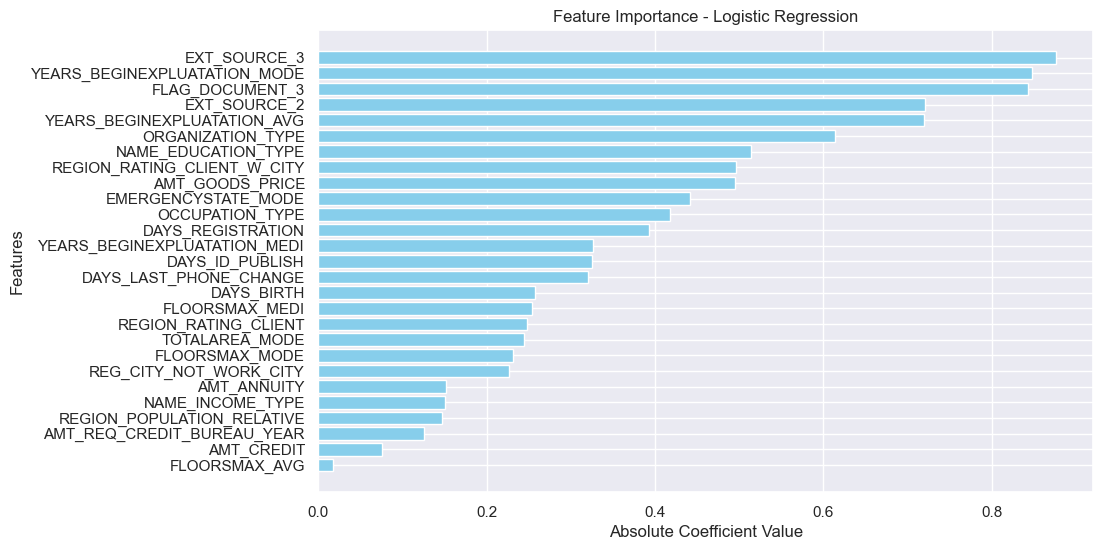

In [29]:
import pandas as pd
import numpy as np

# Extract feature importance 
coefficients = lr.coef_[0]  # Coefficients from the trained logistic regression model
feature_importance = pd.DataFrame({
    'Feature': features_use,
    'Coefficient': coefficients,
    'Importance (abs)': np.abs(coefficients)  
})

# Sort by importance 
feature_importance = feature_importance.sort_values(by='Importance (abs)', ascending=False)
print("Top Features by Importance:")
print(feature_importance.head(10))

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance (abs)'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()  
plt.show()

In [38]:
filtered_df = score_card_df[score_card_df['variable'] == 'NAME_EDUCATION_TYPE']
filtered_df

,variable,binning,score
17,NAME_EDUCATION_TYPE,"Academic degree,Higher education",50.38
18,NAME_EDUCATION_TYPE,"Incomplete higher,Secondary / secondary specia...",13.91
